In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('bmh')

In [2]:
import numpy as np
# Binary regular solution
def energy(H_ex, S_ex, L2_ex, T, x_a, x_b):
    return 8.3145*T*(x_a*np.log(x_a)+x_b*np.log(x_b)) + (H_ex - T*S_ex+L2_ex*T**3)*x_a*x_b

def entropy(H_ex, S_ex, L2_ex, T, x_a, x_b):
    return -(8.3145*(x_a*np.log(x_a)+x_b*np.log(x_b)) + (-S_ex)*x_a*x_b)

def enthalpy(H_ex, S_ex, L2_ex, T, x_a, x_b):
    return energy(H_ex, S_ex, L2_ex, T, x_a, x_b) + T*entropy(H_ex, S_ex, L2_ex, T, x_a, x_b)

In [3]:
import pymc
import numpy as np
rng = np.random.RandomState(42)

# True model parameters, known only by nature
true_H_ex = 7e3
true_S_ex = 5
true_L2_ex = 0

# Some generated "observed" data
# Dataset 1
n1 = 10
dataset1 = {
'n': n1,
'x_a': rng.random_sample((n1,)),
'T': 300,
'func': entropy
}
dataset1['x_b'] = 1 - dataset1['x_a']
# Dataset 2
n2 = 10
dataset2 = {
'n': n2,
'x_a': rng.random_sample((n2,)),
'T': 400,
'func': enthalpy
}
dataset2['x_b'] = 1 - dataset2['x_a']
# Dataset 3
n3 = 10
dataset3 = {
'n': n3,
'x_a': rng.random_sample((n3,)),
'T': 500,
'func': entropy
}
dataset3['x_b'] = 1 - dataset3['x_a']
# Dataset 4
n4 = 10
dataset4 = {
'n': n4,
'x_a': rng.random_sample((n4,)),
'T': 900,
'func': enthalpy
}
dataset4['x_b'] = 1 - dataset4['x_a']
# Dataset 5
n5 = 10
dataset5 = {
'n': n5,
'x_a': rng.random_sample((n5,)),
'T': 1000,
'func': entropy
}
dataset5['x_b'] = 1 - dataset5['x_a']
# Dataset 6
n6 = 10
dataset6 = {
'n': n6,
'x_a': rng.random_sample((n6,)),
'T': 1200,
'func': enthalpy
}
dataset6['x_b'] = 1 - dataset6['x_a']
# Dataset 7
n7 = 10
dataset7 = {
'n': n7,
'x_a': rng.random_sample((n7,)),
'T': 1400,
'func': entropy
}
dataset7['x_b'] = 1 - dataset7['x_a']
# Dataset 8
n8 = 10
dataset8 = {
'n': n8,
'x_a': rng.random_sample((n8,)),
'T': 1600,
'func': enthalpy
}
dataset8['x_b'] = 1 - dataset8['x_a']
# Dataset 9
n9 = 10
dataset9 = {
'n': n9,
'x_a': rng.random_sample((n9,)),
'T': 1800,
'func': entropy
}
dataset9['x_b'] = 1 - dataset9['x_a']
# Dataset 10
n10 = 10
dataset10 = {
'n': n10,
'x_a': rng.random_sample((n10,)),
'T': 1900,
'func': enthalpy
}
dataset10['x_b'] = 1 - dataset10['x_a']

# Observed quantities: true value plus noise
noise1 = rng.normal(0, 0.1, size=dataset1['n'])
noise2 = rng.normal(0, 100, size=dataset2['n'])
noise3 = rng.normal(0, 0.1, size=dataset3['n'])
noise4 = rng.normal(0, 100, size=dataset4['n'])
noise5 = rng.normal(0, 0.1, size=dataset5['n'])
noise6 = rng.normal(0, 100, size=dataset6['n'])
noise7 = rng.normal(0, 0.1, size=dataset7['n'])
noise8 = rng.normal(0, 100, size=dataset8['n'])
noise9 = rng.normal(0, 0.1, size=dataset9['n'])
noise10 = rng.normal(0, 100, size=dataset10['n'])
dataset1['value'] = entropy(true_H_ex, true_S_ex, true_L2_ex, dataset1['T'], dataset1['x_a'], dataset1['x_b']) + noise1
dataset2['value'] = enthalpy(true_H_ex, true_S_ex, true_L2_ex, dataset2['T'], dataset2['x_a'], dataset2['x_b']) + noise2
dataset3['value'] = entropy(true_H_ex, true_S_ex, true_L2_ex, dataset3['T'], dataset3['x_a'], dataset3['x_b']) + noise3
dataset4['value'] = enthalpy(true_H_ex, true_S_ex, true_L2_ex, dataset4['T'], dataset4['x_a'], dataset4['x_b']) + noise4
dataset5['value'] = entropy(true_H_ex, true_S_ex, true_L2_ex, dataset5['T'], dataset5['x_a'], dataset5['x_b']) + noise5
dataset6['value'] = enthalpy(true_H_ex, true_S_ex, true_L2_ex, dataset6['T'], dataset6['x_a'], dataset6['x_b']) + noise6
dataset7['value'] = entropy(true_H_ex, true_S_ex, true_L2_ex, dataset7['T'], dataset7['x_a'], dataset7['x_b']) + noise7
dataset8['value'] = enthalpy(true_H_ex, true_S_ex, true_L2_ex, dataset8['T'], dataset8['x_a'], dataset8['x_b']) + noise8
dataset9['value'] = entropy(true_H_ex, true_S_ex, true_L2_ex, dataset9['T'], dataset9['x_a'], dataset9['x_b']) + noise9
dataset10['value'] = enthalpy(true_H_ex, true_S_ex, true_L2_ex, dataset10['T'], dataset10['x_a'], dataset10['x_b']) + noise10
datasets = [dataset1, dataset2, dataset3, dataset4, dataset5, dataset6, dataset7, dataset8, dataset9, dataset10]

In [35]:
# Priors on unknown parameters
H_ex = pymc.Normal('H_ex', 7e3, 1./(10)**2, value=7e3)
S_ex = pymc.Normal('S_ex', 5, 1./(0.5)**2, value=5)
#H_ex = pymc.Normal('H_ex', 7e3, 1./(10)**2, value=7e3)
#S_ex = pymc.Normal('S_ex', 5, 1./(1)**2, value=5)
L2_ex = pymc.Normal('L2_ex', 0, 1, value=0)
# sig is our std dev of each dataset
sig = pymc.Exponential('sig', np.ones_like(datasets, dtype=np.float), size=len(datasets))
temp = pymc.Normal('T', [400, 400, 500, 900, 1000, 1200, 1400, 1600, 1800, 1900], [1000., 1, 1., 1., 1, 1, 1, 1, 1, 1], size=len(datasets))

# Fit to our energy model
@pymc.potential
def error(H_ex=H_ex, S_ex=S_ex, L2_ex=L2_ex, sig=sig, temp=temp, value=datasets):
    result = np.zeros_like(datasets, dtype=np.float)
    for idx, dataset in enumerate(datasets):
        result[idx] = (np.square(dataset['func'](H_ex, S_ex, L2_ex, temp, dataset['x_a'], dataset['x_b']) - dataset['value'])).mean()
    result /= 2 * sig**2
    return -result.sum()


In [36]:
mod = pymc.Model([H_ex, S_ex, L2_ex, sig, temp, error])

In [37]:
map_ = pymc.MAP(mod).fit()
MDL = pymc.MCMC(mod)
%time MDL.sample(iter=100000, burn=80000, burn_till_tuned=False, thin=2, progress_bar=False)

CPU times: user 2min 12s, sys: 6 ms, total: 2min 12s
Wall time: 2min 12s


Plotting S_ex
Plotting L2_ex
Plotting H_ex


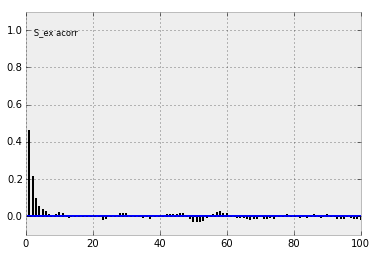

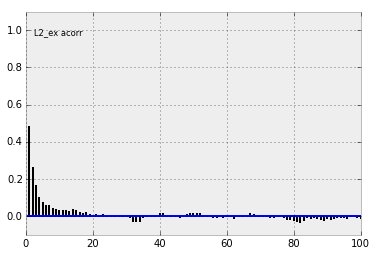

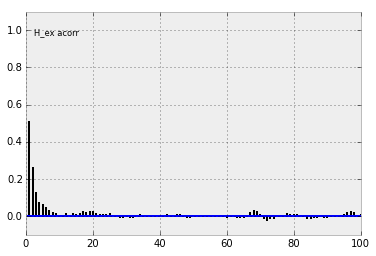

In [38]:
pymc.Matplot.autocorrelation(MDL)

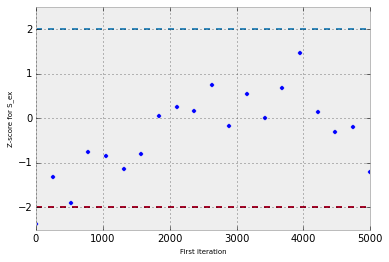

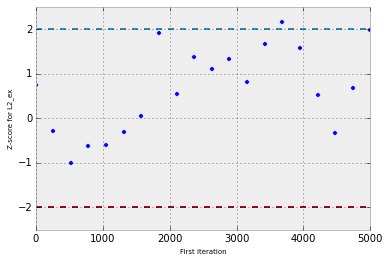

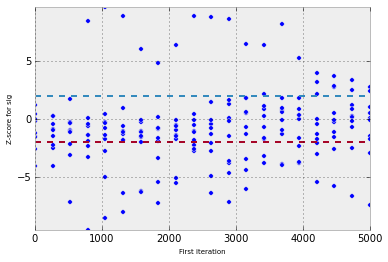

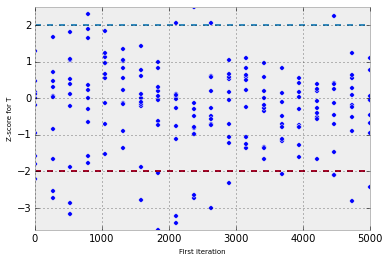

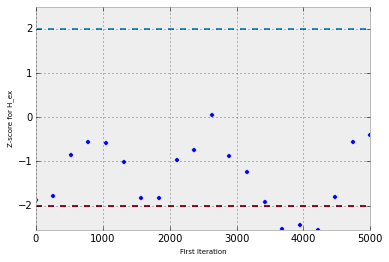

In [39]:
scores = pymc.geweke(MDL, intervals=20)
pymc.Matplot.geweke_plot(scores)

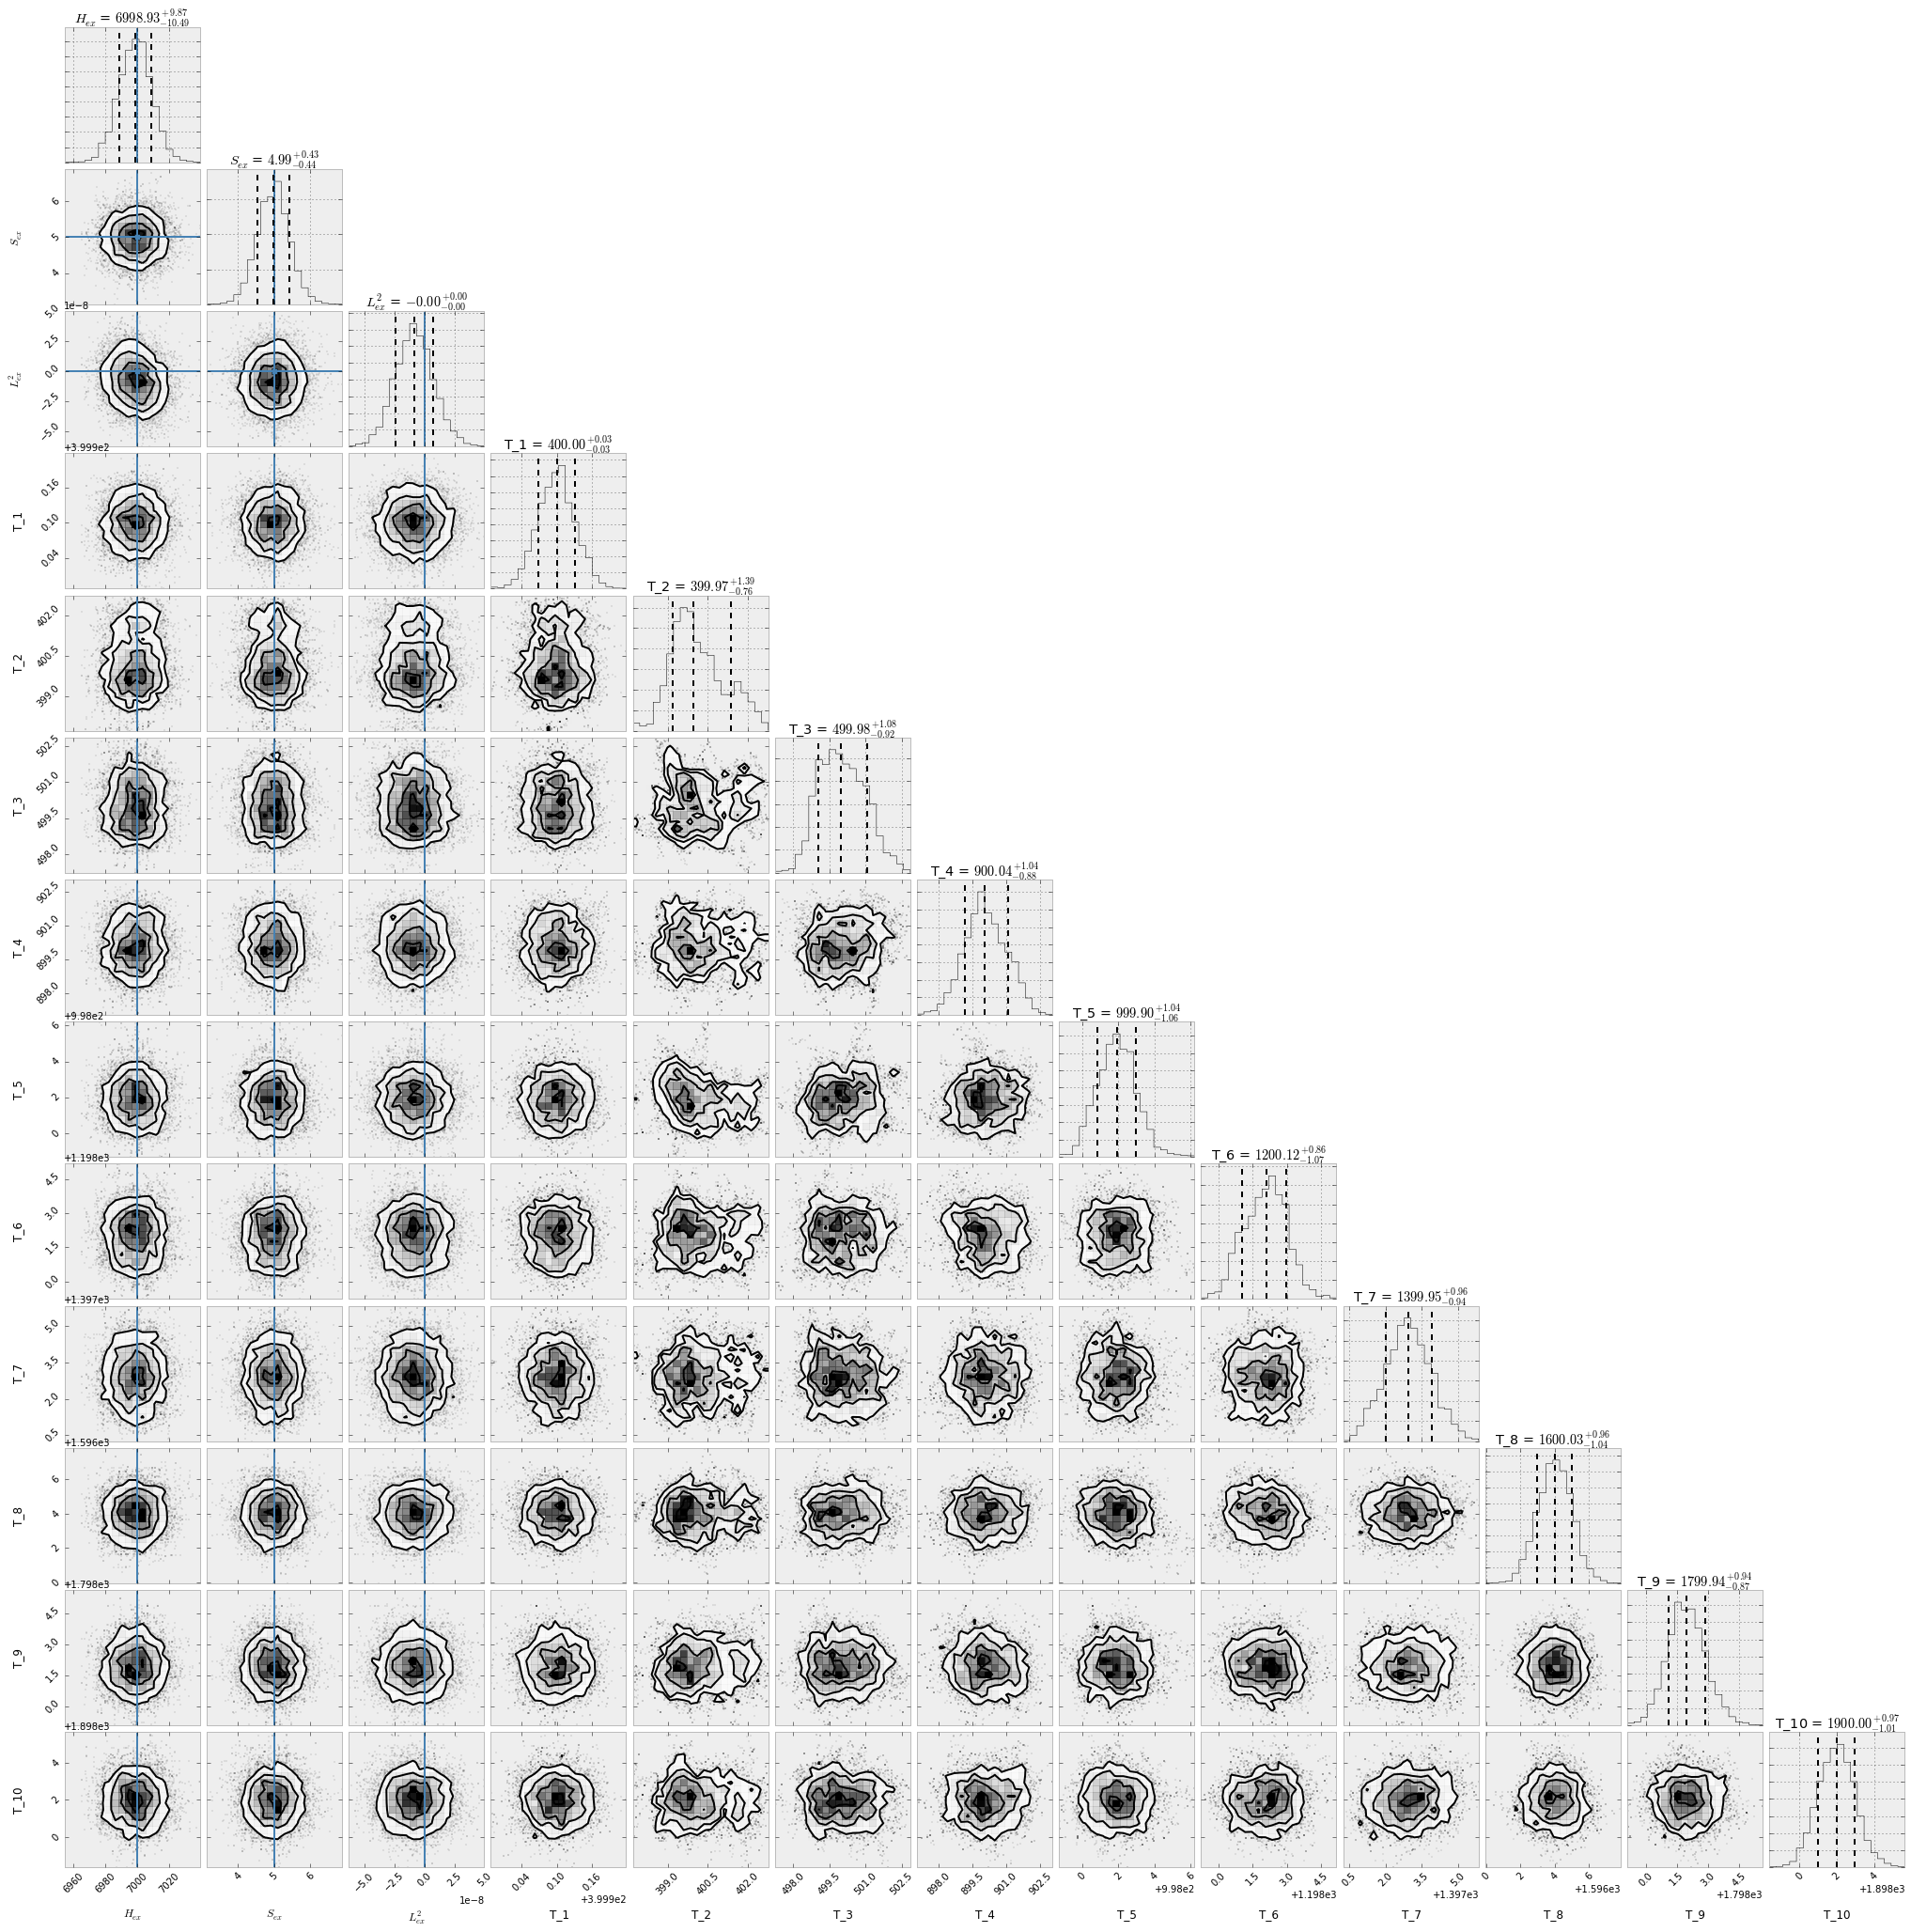

In [41]:
from corner import corner
from itertools import chain
data = np.vstack(chain([H_ex.trace(), S_ex.trace(), L2_ex.trace()], temp.trace().T)).T
corner(data, labels=[r"$H_{ex}$", r"$S_{ex}$", r"$L^2_{ex}$"] + ['T_{}'.format(i+1) for i in range(len(datasets))],
       truths=[true_H_ex, true_S_ex, true_L2_ex] + [None] * len(datasets),
       quantiles=[0.16, 0.5, 0.84],
       show_titles=True, title_args={"fontsize": 40}).show()

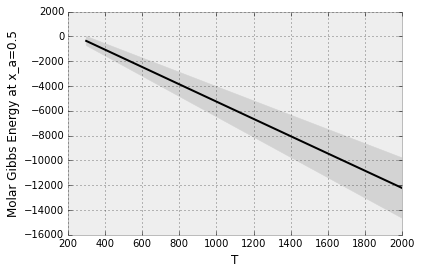

In [10]:
S_ex_tr, H_ex_tr = (S_ex.trace(), H_ex.trace())
Tfit = np.linspace(300, 2000, 100)
Efit = energy(H_ex_tr[:, None], S_ex_tr[:, None], L2_ex, Tfit, 0.5, 0.5)
mu = Efit.value.mean(axis=0)
sigma = 2 * Efit.value.std(axis=0)
plt.plot(Tfit, mu, '-k')
plt.fill_between(Tfit, mu - sigma, mu + sigma, color='lightgray')

plt.xlabel('T')
plt.ylabel('Molar Gibbs Energy at x_a=0.5')

In [11]:
temp = 300 # temperature of interest

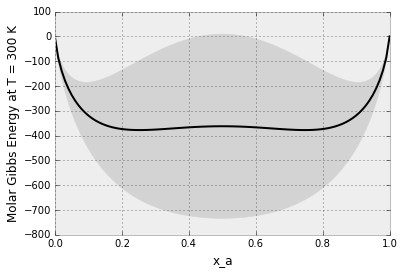

In [12]:
S_ex_tr, H_ex_tr = (S_ex.trace(), H_ex.trace())
xfit = np.linspace(1e-8, 1.-1e-8, 100)
yfit = energy(H_ex_tr[:, None], S_ex_tr[:, None], L2_ex, temp, xfit, 1-xfit)
mu = yfit.value.mean(axis=0)
sigma = 2 * yfit.value.std(axis=0)
plt.plot(xfit, mu, '-k')
plt.fill_between(xfit, mu - sigma, mu + sigma, color='lightgray')

plt.xlim(0,1)
plt.xlabel('x_a')
plt.ylabel('Molar Gibbs Energy at T = {} K'.format(temp))

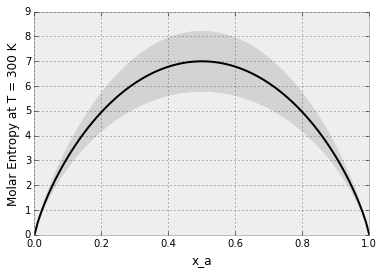

In [13]:
S_ex_tr, H_ex_tr = (S_ex.trace(), H_ex.trace())
xfit = np.linspace(1e-8, 1.-1e-8, 100)
yfit = entropy(H_ex_tr[:, None], S_ex_tr[:, None], L2_ex, temp, xfit, 1-xfit)
mu = yfit.mean(axis=0)
sigma = 2 * yfit.std(axis=0)
plt.plot(xfit, mu, '-k')
plt.fill_between(xfit, mu - sigma, mu + sigma, color='lightgray')

plt.xlabel('x_a')
plt.ylabel('Molar Entropy at T = {} K'.format(temp))

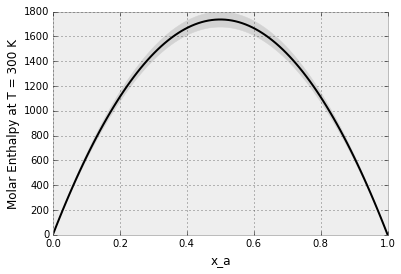

In [14]:
S_ex_tr, H_ex_tr = (S_ex.trace(), H_ex.trace())
xfit = np.linspace(1e-8, 1.-1e-8, 100)
yfit = enthalpy(H_ex_tr[:, None], S_ex_tr[:, None], L2_ex, temp, xfit, 1-xfit)
mu = yfit.value.mean(axis=0)
sigma = 2 * yfit.value.std(axis=0)
plt.plot(xfit, mu, '-k')
plt.fill_between(xfit, mu - sigma, mu + sigma, color='lightgray')

plt.xlabel('x_a')
plt.ylabel('Molar Enthalpy at T = {} K'.format(temp))